<a href="https://colab.research.google.com/github/NMashalov/2023_OpenMipt_course/blob/main/lesson10/sem_neparam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from statsmodels.sandbox.stats.multicomp import multipletests
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

### Критерий Смирнова <font color="red">(независимые выборки)</font>

$X_1, ..., X_n$ и $Y_1, ..., Y_m$ &mdash; независимые выборки, имеющие непрерывные функции распределения $F$ и $G$ соответственно.

$\mathsf{H}_0\colon F = G$

$\mathsf{H}_1\colon F \not= G$

Альтернатива двусторонняя, б*о*льшие значения статистики являются более экстремальными.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp">`ks_2samp`</a>`(data1, data2): statistic, pvalue`

* `data1`, `data2` &mdash; две выборки

---

Определим несколько вспомогательных функций для отрисовки графиков

In [3]:
def ecdf(sample):
    """
    Вычисляет точки по X и по Y для построения ЭФР по выборке sample.
    Учитываются как горизонтальные, так и вертикальные линии.
    """

    # дублируем выборку и добавляем значения слева и справа
    x = deepcopy(list(sample)*2 + [sample.min()-0.5, sample.max()+0.5])
    # каждое значение два раза
    y = deepcopy(list(np.linspace(0, 1, len(sample)+1)) * 2)

    return np.sort(x), np.sort(y)


def max_diff(x1, x2, y1, y2):
    """ Вычисляет, где достигается максимальная разница между двумя ЭФР. """

    # объединим наборы и отсортируем по иксу
    x_all, y_all = np.hstack([x1, x2]), np.hstack([y1, y2])
    order = np.argsort(x_all)
    x_all, y_all = x_all[order], y_all[order]

    # найдем индекс наибольшей разницы по Y между соседними
    i = np.argmax(np.abs(y_all[1:] - y_all[:-1]))

    # точка наибольшей разности и значения  в ней
    return (x_all[i+1] + x_all[i]) / 2, y_all[i], y_all[i+1]

In [4]:
def apply_smirnov(distr1, distr2, size1=100, size2=100):
    """
    Генерирует выборки из заданных распределений,
    строит графики теоретических и эмпирических функций распределения,
    применяет критерий Смирнова.

    distr1, distr2 &mdash; распределения для генерации выборок
    size1, size2 &mdash; размеры выборок
    """

    # генерируем выборки
    sample_1 = distr1.rvs(size=size1)
    sample_2 = distr2.rvs(size=size2)

    # определяем границы графика
    x_min = min(distr1.ppf(0.01), distr2.ppf(0.01))
    x_max = max(distr1.ppf(0.99), distr2.ppf(0.99))
    grid = np.linspace(x_min, x_max, 200)

    plt.figure(figsize=(16, 5))

    # График истинных функций распределения
    plt.subplot(121)
    plt.plot(grid, distr1.cdf(grid), lw=3)
    plt.plot(grid, distr2.cdf(grid), lw=3)
    plt.title('CDF')

    # График эмпирических функций распределения
    plt.subplot(122)
    x1, y1 = ecdf(sample_1)
    plt.plot(x1, y1, lw=3)
    x2, y2 = ecdf(sample_2)
    plt.plot(x2, y2, lw=3)
    plt.vlines(*max_diff(x1, x2, y1, y2), color='gray')
    plt.title('ECDF')

    # Применяем критерий Смирнова
    print(sps.ks_2samp(sample_1, sample_2))

Сравним нормальные с разными средними

KstestResult(statistic=0.41, pvalue=6.617357604827955e-08, statistic_location=0.5022665615799234, statistic_sign=1)


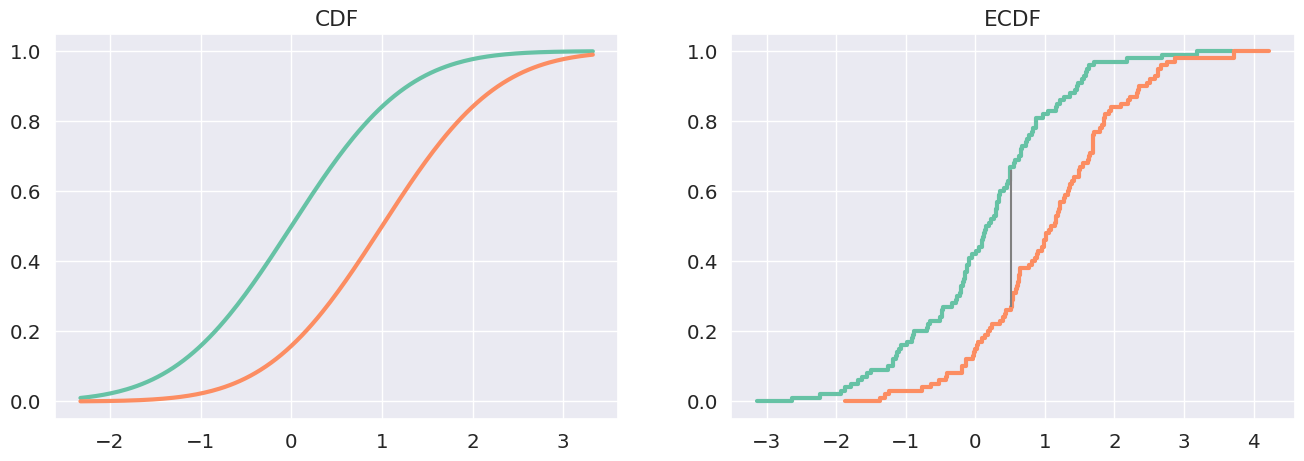

In [5]:
apply_smirnov(sps.norm(loc=0), sps.norm(loc=1))

Сравним нормальные с разными дисперсиями и разными размерами выборок

KstestResult(statistic=0.2806666666666667, pvalue=0.018388616021824896, statistic_location=1.1456552798192003, statistic_sign=1)


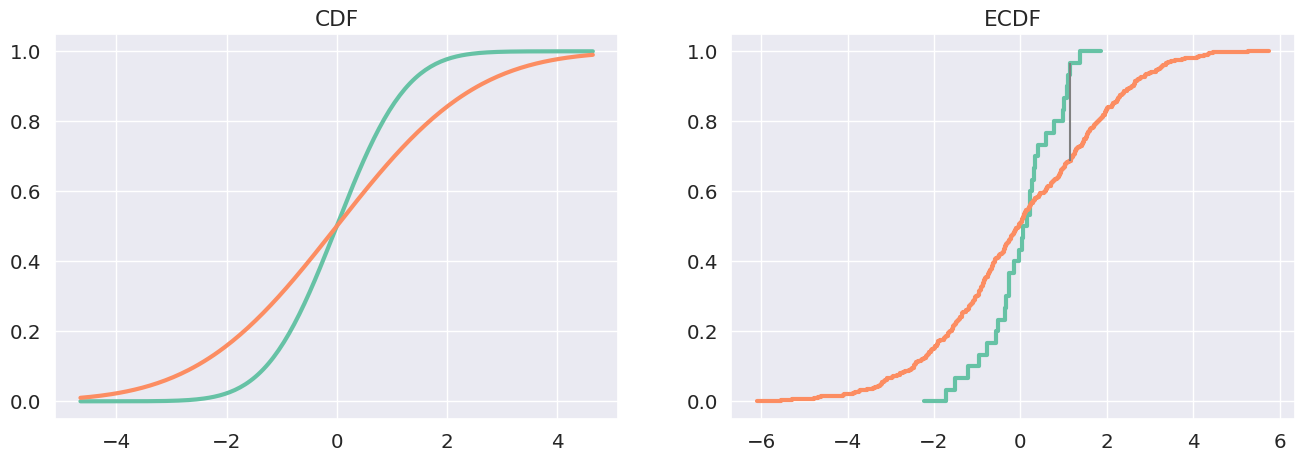

In [6]:
apply_smirnov(sps.norm(loc=0, scale=1), sps.norm(loc=0, scale=2),
              size1=30, size2=500)

Если увеличить размер выборки

KstestResult(statistic=0.184, pvalue=8.2169644411341e-08, statistic_location=1.5423991154101868, statistic_sign=1)


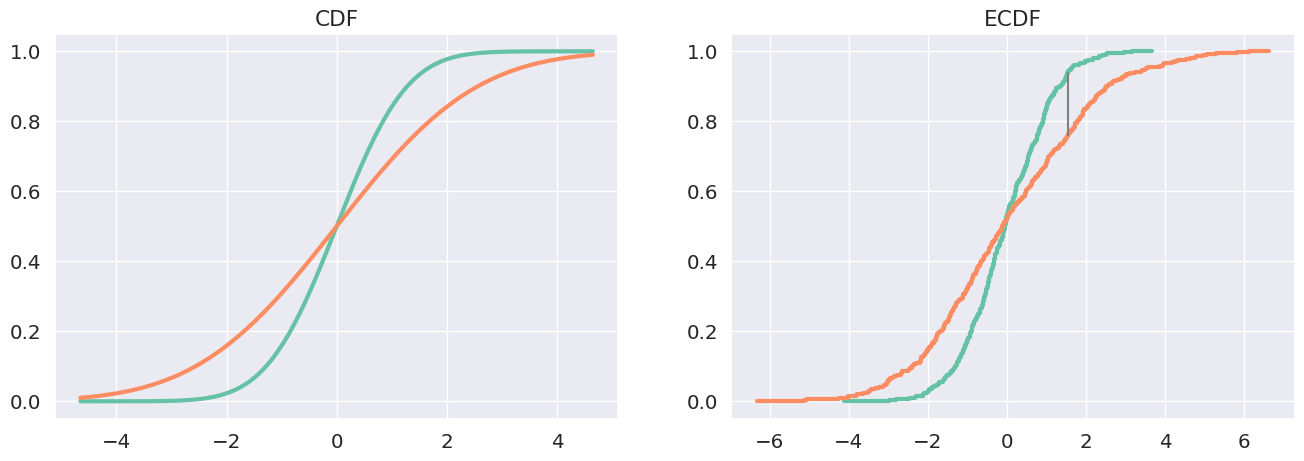

In [7]:
apply_smirnov(sps.norm(loc=0, scale=1), sps.norm(loc=0, scale=2),
              size1=500, size2=500)

Маленькое отклонение при очень больших выборках

KstestResult(statistic=0.006339999999999998, pvalue=0.26627154735665914, statistic_location=-1.1568129978329855, statistic_sign=1)


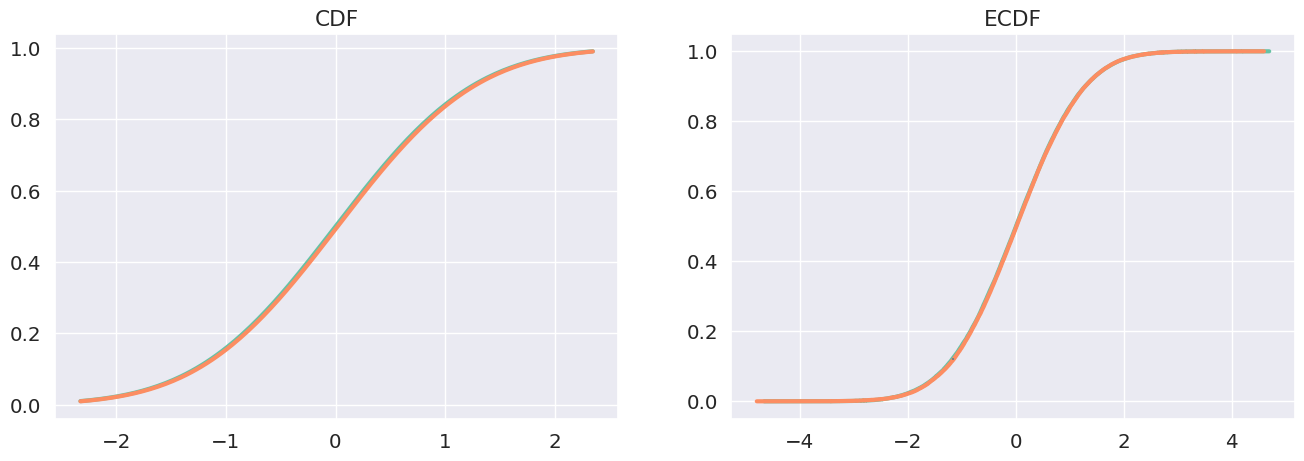

In [8]:
apply_smirnov(sps.norm, sps.norm(loc=0.02),
              size1=50000, size2=50000)

Сравним нормальное и Коши

KstestResult(statistic=0.16, pvalue=0.1548386665118475, statistic_location=1.8139478916154448, statistic_sign=1)


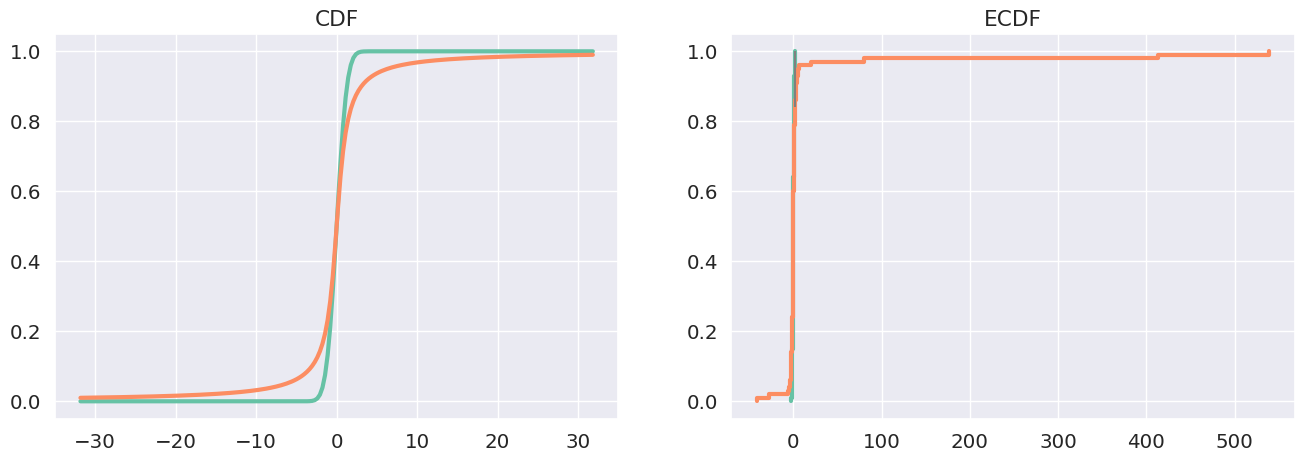

In [9]:
apply_smirnov(sps.norm, sps.cauchy)

Сравним нормальное и Лапласса

KstestResult(statistic=0.17, pvalue=0.11119526053829192, statistic_location=-0.5053313069690879, statistic_sign=1)


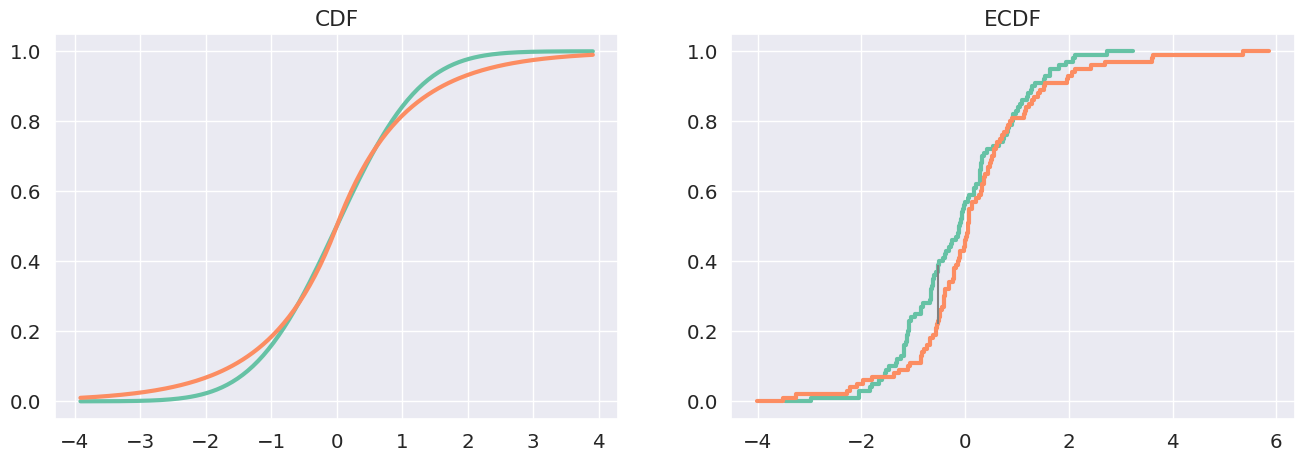

In [10]:
apply_smirnov(sps.norm, sps.laplace)

### Критерий ранговых сумм Уилкоксона-Манна-Уитни <font color="red">(независимые выборки)</font>

$X_1, ..., X_n$ и $Y_1, ..., Y_m$ &mdash; независимые выборки, имеющие непрерывные функции распределения $F$ и $G$ соответственно.

------

**"Критерий Уилкоксона"**

$\mathsf{H}_0\colon F = G$

$\mathsf{H}_1\colon \{F \leqslant G \text{ или } F \geqslant G\}$, причем это не значит, что $\mathsf{H}_1\colon F \not= G$.

Используется нормированная версия статистики $V = S_1 + ... + S_m$ &mdash; сумма рангов наблюдений $Y_j$ по объединенной выборке.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html#scipy.stats.ranksums">`ranksums`</a>`(data1, data2): statistic, pvalue`

* `data1`, `data2` &mdash; две выборки.

------

**"Критерий Манна-Уитни"**

$\mathsf{H}_0\colon F = G$

$\mathsf{H}_1\colon F \leqslant G$ или $\mathsf{H}_1\colon F \geqslant G$ или $\mathsf{H}_1\colon \{F \leqslant G \text{ или } F \geqslant G\}$

Используется статистика $U = \sum\limits_{i=1}^n \sum\limits_{j=1}^m I\{X_i < Y_j\}$, причем $U = V - \frac{m(m+1)}{2}$.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu">`mannwhitneyu`</a>`(data1, data2, use_continuity=True, alternative=None): statistic, pvalue`

* `data1`, `data2` &mdash; две выборки;

* `use_continuity` &mdash; использовать ли поправку 0.5 на непрерывность;
* `alternative='less'` &mdash; используется альтернатива $\mathsf{H}_1\colon F \leqslant G$;
* `alternative='greater'` &mdash; используется альтернатива $\mathsf{H}_1\colon F \geqslant G$;
* `alternative='two-sided'` &mdash; используется альтернатива $\mathsf{H}_1\colon \{F \leqslant G \text{ или } F \geqslant G\}$, причем эквивалентен `ranksums`.

---

Примеры

In [ ]:
def print_tests(sample_1, sample_2):
    print(sps.ranksums(sample_1, sample_2))
    print('two-sided:', sps.mannwhitneyu(sample_1, sample_2, alternative='two-sided'))
    print('less:     ', sps.mannwhitneyu(sample_1, sample_2, alternative='less'))
    print('greater:  ', sps.mannwhitneyu(sample_1, sample_2, alternative='greater'))

In [ ]:
print_tests(sps.norm.rvs(size=100), sps.norm.rvs(size=100))

RanksumsResult(statistic=0.48379099965096867, pvalue=0.6285342032181189)
two-sided: MannwhitneyuResult(statistic=5198.0, pvalue=0.6294015779777652)
less:      MannwhitneyuResult(statistic=5198.0, pvalue=0.6861663295178713)
greater:   MannwhitneyuResult(statistic=5198.0, pvalue=0.3147007889888826)


In [ ]:
print_tests(sps.norm.rvs(size=100), sps.norm(loc=1).rvs(size=100))

RanksumsResult(statistic=-5.426766718307078, pvalue=5.73840493580879e-08)
two-sided: MannwhitneyuResult(statistic=2779.0, pvalue=5.7777962828839014e-08)
less:      MannwhitneyuResult(statistic=2779.0, pvalue=2.8888981414419507e-08)
greater:   MannwhitneyuResult(statistic=2779.0, pvalue=0.9999999715036306)


In [ ]:
print_tests(sps.norm.rvs(size=100), sps.norm(loc=1, scale=10).rvs(size=100))

RanksumsResult(statistic=-0.9040538882366587, pvalue=0.3659668276382603)
two-sided: MannwhitneyuResult(statistic=4630.0, pvalue=0.36661496200700283)
less:      MannwhitneyuResult(statistic=4630.0, pvalue=0.18330748100350142)
greater:   MannwhitneyuResult(statistic=4630.0, pvalue=0.8173402956379232)


In [ ]:
print_tests(sps.cauchy.rvs(size=100), sps.cauchy(loc=1).rvs(size=100))

RanksumsResult(statistic=-2.2796818316886553, pvalue=0.02262656562129269)
two-sided: MannwhitneyuResult(statistic=4067.0, pvalue=0.022699176931258253)
less:      MannwhitneyuResult(statistic=4067.0, pvalue=0.011349588465629126)
greater:   MannwhitneyuResult(statistic=4067.0, pvalue=0.9887229218710648)


### Критерий ранговых сумм Уилкоксона <font color="red">(парные выборки)</font>

$X_1, ..., X_n$ и $Y_1, ..., Y_n$ &mdash; связные выборки, имеющие непрерывные функции распределения $F$ и $G$ соответственно.

Предполагается, что $Z_i = Y_i - X_i = \theta + \varepsilon_i$, причем $\varepsilon_i$ независимы одинаково распределены, причем распределение непрерывное симметричное относительно нуля.

Проверяются гипотезы

$\mathsf{H}_0\colon \theta = 0$,

$\mathsf{H}_1\colon \theta \not= 0$.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon">`wilcoxon`</a>`(x, y=None, zero_method='wilcox'): statistic, pvalue`

* `x`, `y` &mdash; выборки. Если `y=None`, то в `x` разности;
* `zero_method='pratt'` &mdash; нулевые разности остаются (более консервативен);
* `zero_method='wilcox'` &mdash; нулевые разности выкивываются;
* `zero_method='zsplit'` &mdash; нулевые разности распределяются между положительными и отрицательными рангами.

---

Примеры:

In [ ]:
sample_1 = sps.norm(loc=0).rvs(size=100)
sample_2 = sample_1 + sps.norm(loc=0, scale=0.5).rvs(size=100)
sps.wilcoxon(sample_1, sample_2)

WilcoxonResult(statistic=2330.0, pvalue=0.5025560930996884)

In [ ]:
sample_1 = sps.norm(loc=0).rvs(size=100)
sample_2 = sample_1 + sps.norm(loc=0.5, scale=0.5).rvs(size=100)
sps.wilcoxon(sample_1, sample_2)

WilcoxonResult(statistic=317.0, pvalue=3.154399659417182e-14)

In [ ]:
sample_1 = sps.norm(loc=0).rvs(size=100)
sample_2 = sample_1 + sps.norm(loc=-0.5, scale=0.5).rvs(size=100)
sps.wilcoxon(sample_1, sample_2)

WilcoxonResult(statistic=431.0, pvalue=6.027785259387459e-13)

Времена реакции (Лагутин)

In [ ]:
sample_1 = [176, 163, 152, 155, 156, 178, 160, 164, 169, 155, 122, 144]
sample_2 = [168, 215, 172, 200, 191, 197, 183, 174, 176, 155, 115, 163]
print('wilcox:', sps.wilcoxon(sample_1, sample_2))
print('pratt: ', sps.wilcoxon(sample_1, sample_2, zero_method='pratt'))
print('zsplit:', sps.wilcoxon(sample_1, sample_2, zero_method='zsplit'))

wilcox: WilcoxonResult(statistic=4.5, pvalue=0.011197738894413023)
pratt:  WilcoxonResult(statistic=6.5, pvalue=0.011931715346446874)
zsplit: WilcoxonResult(statistic=7.0, pvalue=0.011997435448298963)


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


# Отток клиентов телекома

Загрузим <a href="https://github.com/Yorko/mlcourse_open/blob/master/data/telecom_churn.csv">данные</a> о клиентах оператора связи, которые содержат некоторую информацию тарифном плане клиента, статистику его использования услуг связи, а также его текущий статус `Churn` &mdash; ушел или нет.

In [ ]:
telecom = pd.read_csv('./telecom_churn.csv')
telecom.head()

### Одинаково ли распределено количество минут днем?

In [ ]:
plt.figure(figsize=(12, 5))
sns.kdeplot(telecom[telecom['Churn'] == False]['Total day minutes'],
            label='False', lw=3)
sns.kdeplot(telecom[telecom['Churn'] == True]['Total day minutes'],
            label='True', lw=3)
plt.legend(title='Churn')

plt.title('Ядерная оценка плотности при разных фиксированных значениях Churn')
plt.ylabel('Плотность')
plt.xlabel('Признак Total day minutes')

plt.show()

Проверьте гипотезу однородности, какой критерий вы бы выбрали? Какую альтернативу стоит использовать?

**Ответ:**

In [ ]:
x = telecom[telecom['Churn'] == False]['Total day minutes']
y = telecom[telecom['Churn'] == True]['Total day minutes']

<...>

Для дальнейшего использования реализуем функцию оценки сдвига и функцию доверительного интервала оценки.

Учтите, что по сравнению с формулами для доверительного интервала из индексов надо вычесть 1, поскольку используется нумерация с нуля.

In [ ]:
def shift(x, y):
  # оценка параметра сдвига из критерия ранговых сумм Уилкоксона
  shift = <...>
  return shift

def confidence_interval(x, y, alpha=0.05):
  # доверительный интервал параметра сдвига из критерия ранговых сумм Уилкоксона
  k_a = <...>
  left, right = <...>
  return left, right

Оценим сдвиг

Получите доверительный интервал величины сдвига.

### Одинаково ли распределено количество минут ночью?

In [ ]:
plt.figure(figsize=(12, 5))
sns.kdeplot(telecom[telecom['Churn'] == False]['Total night minutes'],
            label='False', lw=3)
sns.kdeplot(telecom[telecom['Churn'] == True]['Total night minutes'],
            label='True', lw=3)
plt.xlabel('Признак Total day minutes')
plt.legend(title='Churn')

plt.title('Ядерная оценка плотности для разных значений Churn')
plt.ylabel('Плотность')

plt.show()

Проверьте с помощью критерия.

In [ ]:
x = telecom[telecom['Churn'] == False]['Total night minutes']
y = telecom[telecom['Churn'] == True]['Total night minutes']

<...>

Получим оценку сдвига.

Получим доверительный интервал.

Что вы можете сказать о проверке критерием, об оценке сдвига и о её доверительном интервале?

**Ответ:**

Распределения по графику похожи на нормальные, проверьте эту гипотезу. При прохождении критерия проверьте параметрическим критерием однородность выборок. Нужно ли использовать что-то ещё при проверке?

**Вывод:**